# Лабораторная работа 3
### Выполнил: Затопляев Ростислав Артемович

### EDA (исследовательский анализ данных)

In [61]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#### Выполним настройки воспроизводимости

In [62]:
def set_seed(seed=777):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(777)

In [63]:
# Загрузка данных
train_labels = pd.read_csv('/content/train_labels.csv')

#### Просмотр структуры и типов данных

In [16]:
print("Структура данных:")
print(train_labels.info())
print("\nПервые 5 строк:")
print(train_labels.head())

Структура данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8997 entries, 0 to 8996
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   left_eye_x     8997 non-null   float64
 1   left_eye_y     8997 non-null   float64
 2   right_eye_x    8997 non-null   float64
 3   right_eye_y    8997 non-null   float64
 4   mouth_x        8997 non-null   float64
 5   mouth_y        8997 non-null   float64
 6   left_ear_1_x   8997 non-null   float64
 7   left_ear_1_y   8997 non-null   float64
 8   left_ear_2_x   8997 non-null   float64
 9   left_ear_2_y   8997 non-null   float64
 10  left_ear_3_x   8997 non-null   float64
 11  left_ear_3_y   8997 non-null   float64
 12  right_ear_1_x  8997 non-null   float64
 13  right_ear_1_y  8997 non-null   float64
 14  right_ear_2_x  8997 non-null   float64
 15  right_ear_2_y  8997 non-null   float64
 16  right_ear_3_x  8997 non-null   float64
 17  right_ear_3_y  8997 non-null   flo

#### Проверка на пропущенные значения

In [17]:
print("\nПропущенные значения в данных:")
missing = train_labels.isnull().sum()
print(missing)
if missing.sum() > 0:
    print("\n Обнаружены пропущенные значения")


Пропущенные значения в данных:
left_eye_x       0
left_eye_y       0
right_eye_x      0
right_eye_y      0
mouth_x          0
mouth_y          0
left_ear_1_x     0
left_ear_1_y     0
left_ear_2_x     0
left_ear_2_y     0
left_ear_3_x     0
left_ear_3_y     0
right_ear_1_x    0
right_ear_1_y    0
right_ear_2_x    0
right_ear_2_y    0
right_ear_3_x    0
right_ear_3_y    0
file_name        0
dtype: int64


#### Проверка на явные выбросы

In [19]:
min_vals = train_labels[coords_columns].min()
max_vals = train_labels[coords_columns].max()
print(f"\nМинимальные значения по координатам:\n{min_vals}")
print(f"\nМаксимальные значения по координатам:\n{max_vals}")


Минимальные значения по координатам:
left_eye_x        29.0
left_eye_y        19.0
right_eye_x       55.0
right_eye_y       22.0
mouth_x           32.0
mouth_y           55.0
left_ear_1_x     -44.0
left_ear_1_y     -37.0
left_ear_2_x    -188.0
left_ear_2_y    -214.0
left_ear_3_x      24.0
left_ear_3_y     -96.0
right_ear_1_x     37.0
right_ear_1_y   -106.0
right_ear_2_x      0.0
right_ear_2_y   -235.0
right_ear_3_x     59.0
right_ear_3_y    -61.0
dtype: float64

Максимальные значения по координатам:
left_eye_x        902.0
left_eye_y        786.0
right_eye_x       952.0
right_eye_y       783.0
mouth_x           976.0
mouth_y           876.0
left_ear_1_x      897.0
left_ear_1_y      844.0
left_ear_2_x     1063.0
left_ear_2_y      894.0
left_ear_3_x      922.0
left_ear_3_y      827.0
right_ear_1_x     968.0
right_ear_1_y     828.0
right_ear_2_x    1156.0
right_ear_2_y     935.0
right_ear_3_x    1011.0
right_ear_3_y     778.0
dtype: float64


#### Проверка на битые изображения

In [64]:
def is_image_broken(img_path):
    img = cv2.imread(img_path)
    return img is None

broken_images = []
image_sizes = []

train_img_dir = "/content/images/images/train"
for img_name in train_labels['file_name']:
    img_path = os.path.join(train_img_dir, img_name)
    if not os.path.exists(img_path):
        broken_images.append(img_name)
        continue
    img = cv2.imread(img_path)
    if img is None:
        broken_images.append(img_name)
    else:
        image_sizes.append((img.shape[1], img.shape[0]))  # width, height

print(f"\nНайдено битых/отсутствующих изображений: {len(broken_images)}")
if broken_images:
    print("Список (первые 10):", broken_images[:10])


Найдено битых/отсутствующих изображений: 0


#### Статистика по размерам изображений

In [65]:
if image_sizes:
    widths, heights = zip(*image_sizes)
    print(f"\nСредняя ширина: {np.mean(widths):.2f}, средняя высота: {np.mean(heights):.2f}")
    print(f"Минимальные размеры: {min(widths)}x{min(heights)}")
    print(f"Максимальные размеры: {max(widths)}x{max(heights)}")


Средняя ширина: 604.79, средняя высота: 520.37
Минимальные размеры: 135x101
Максимальные размеры: 1024x1024


#### Реализуем функцию для отрисовки ключевых точек

<Figure size 1500x600 with 0 Axes>

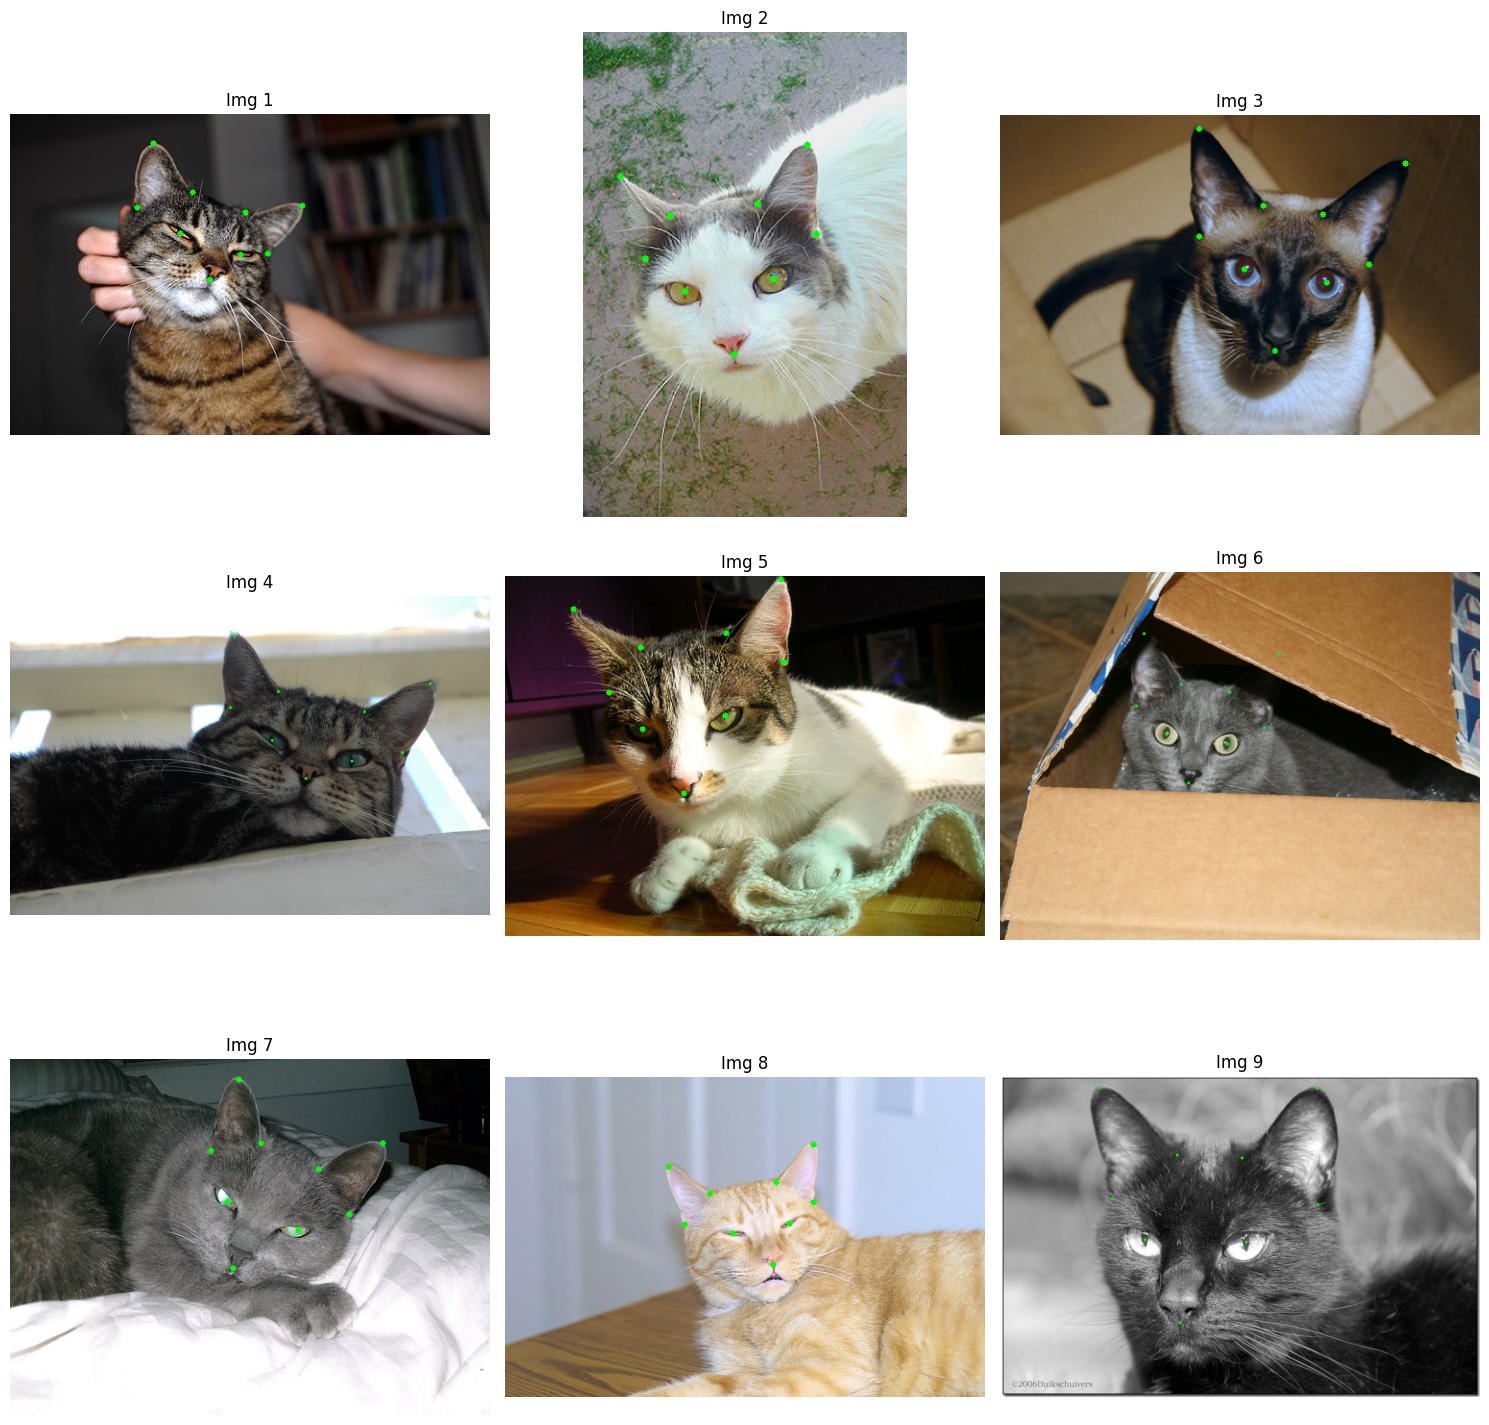

In [66]:
def plot_keypoints(image_path, keypoints, title=""):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Рисуем точки
    for i in range(0, len(keypoints), 2):
        x = int(keypoints[i])
        y = int(keypoints[i+1])
        # Проверка, чтобы точка была внутри изображения
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            cv2.circle(img, (x, y), radius=3, color=(0, 255, 0), thickness=-1)
        else:
            print(f" Точка ({x}, {y}) вне границ изображения!")

    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Визуализация нескольких примеров
plt.figure(figsize=(15, 6))
num_examples = min(9, len(train_labels))
cols = 3
rows = (num_examples + cols - 1) // cols

plt.figure(figsize=(5 * cols, 5 * rows))

for i in range(num_examples):
    row = train_labels.iloc[i]
    img_path = f"/content/images/images/train/{row['file_name']}"
    kps = row.drop('file_name').values.astype(float)

    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Рисуем ключевые точки
    for j in range(0, len(kps), 2):
        x, y = int(kps[j]), int(kps[j+1])
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            cv2.circle(img, (x, y), radius=3, color=(0, 255, 0), thickness=-1)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Img {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Preprocessing (подготовка данных)

#### Реализуем кастомный класс для подгрузки данных с аугментациями. Аугментации нам помогут увеличить разнообразие данных и улучшить обобщающую способность модели

In [86]:
class CatKeypointsDataset(Dataset):

    def __init__(self, csv_file, img_dir, transform=None, img_size=(224, 224)):

        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.img_size = img_size

        # Удаляем имя файла из меток
        self.keypoint_cols = [col for col in self.labels.columns if col != 'file_name']
        self.labels[self.keypoint_cols] = self.labels[self.keypoint_cols].fillna(0)

        # Создаем аугментации
        if transform is None:
            self.augmentations = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
            ])
        else:
            self.augmentations = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx]['file_name']
        img_path = os.path.join(self.img_dir, img_name)

        # Загрузка изображения
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Извлечение ключевых точек
        keypoints = self.labels.iloc[idx][self.keypoint_cols].values.astype(np.float32)

        # Сохраняем оригинальные размеры для денормализации
        orig_h, orig_w = image.shape[:2]

        # Resize изображения
        image = cv2.resize(image, self.img_size)

        # Применяем аугментации
        if self.transform is not None:
            image = self.augmentations(image)
        else:
            image = image / 255.0  # Нормализация в [0,1]
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        # Нормализация координат ключевых точек
        for i in range(0, len(keypoints), 2):
            keypoints[i] = keypoints[i] / orig_w
            keypoints[i+1] = keypoints[i+1] / orig_h

        return image, keypoints, orig_w, orig_h

### Training/evaluation loop

#### Функция для обучения модели. Возвращает историю обучения для анализа. Используем раннюю остановку для экономии времени.

In [68]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs=10, device='cuda', early_stopping_patience=3, log_every=50):

    if isinstance(device, str):
        device = torch.device(device)
    elif not isinstance(device, torch.device):
        raise ValueError("error")

    model = model.to(device)
    history = {'train_loss': [], 'val_loss': []}
    scaler = torch.amp.GradScaler(device.type) if device.type == 'cuda' else None

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Обучение
        model.train()
        train_loss = 0.0
        batch_count = 0

        for batch_idx, (images, keypoints, _, _) in enumerate(train_loader):
            images, keypoints = images.to(device), keypoints.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast(device_type=device.type, enabled=(scaler is not None)):
                outputs = model(images)
                loss = criterion(outputs, keypoints)

            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            train_loss += loss.item()
            batch_count += 1

            # Логируем
            if (batch_idx + 1) % log_every == 0 or (batch_idx + 1) == len(train_loader):
                avg_batch_loss = train_loss / batch_count
                print(f"[Batch {batch_idx+1}/{len(train_loader)}] Avg Train Loss: {avg_batch_loss:.4f}")

        # Средний loss за эпоху
        train_loss /= len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, keypoints, _, _ in val_loader:
                images, keypoints = images.to(device), keypoints.to(device)
                with torch.amp.autocast(device_type=device.type, enabled=(scaler is not None)):
                    outputs = model(images)
                    loss = criterion(outputs, keypoints)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Сохраняем и выводим итоги эпохи
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"   Train Loss: {train_loss:.6f}")
        print(f"   Val Loss:   {val_loss:.6f}")

        # Ранняя остановка
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), '/content/drive/MyDrive/contest3/best_model.pth')
            torch.save(model.state_dict(), '/content/best_model.pth')
            print("    Новая лучшая модель сохранена")
        else:
            patience_counter += 1
            print(f"   Patience: {patience_counter}/{early_stopping_patience}")
            if patience_counter >= early_stopping_patience:
                print(f"\nРанняя остановка на эпохе {epoch+1}")
                break

    # Загружаем лучшую модель
    model.load_state_dict(torch.load('/content/best_model.pth'))
    return history, model

### Prediction function

#### Реализуем функцию для получения предсказаний. Собирает предсказания из всех батчей и возвращает их в удобном формате.

In [87]:
def predict(model, dataloader, device='cuda'):
    if device == 'cuda' and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    model.eval()
    model = model.to(device)

    all_preds = []
    all_targets = []
    all_dims = []

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 4 and isinstance(batch[1], torch.Tensor):
                # Тренировочный датасет с ключевыми точками
                images, keypoints, orig_w, orig_h = batch
                images = images.to(device)
                outputs = model(images)

                all_preds.append(outputs.cpu().numpy())
                all_targets.append(keypoints.numpy())
                all_dims.extend(list(zip(orig_w.numpy(), orig_h.numpy())))
            else:
                # Тестовый датасет (без меток)
                if len(batch) == 4:
                    images, img_names, orig_w, orig_h = batch
                else:
                    images, orig_w, orig_h = batch
                    img_names = None

                images = images.to(device)
                outputs = model(images)

                all_preds.append(outputs.cpu().numpy())
                all_dims.extend(list(zip(orig_w.numpy(), orig_h.numpy())))

    all_preds = np.concatenate(all_preds, axis=0)

    if len(all_targets) > 0:
        all_targets = np.concatenate(all_targets, axis=0)
        return all_preds, all_targets, all_dims
    else:
        return all_preds, all_dims

### Experiments

#### Для экономии времени используем раннюю остановку и проверяем только ключевые гиперпараметры.

#### Эксперимент 1

#### Используем базовую сверточную сеть

Epoch 1/10
[Batch 50/225] Avg Train Loss: 0.2666
[Batch 100/225] Avg Train Loss: 0.1910
[Batch 150/225] Avg Train Loss: 0.1634
[Batch 200/225] Avg Train Loss: 0.1484
[Batch 225/225] Avg Train Loss: 0.1428

Epoch 1 Summary:
   Train Loss: 0.142837
   Val Loss:   0.102612
    Новая лучшая модель сохранена
Epoch 2/10
[Batch 50/225] Avg Train Loss: 0.1011
[Batch 100/225] Avg Train Loss: 0.0984
[Batch 150/225] Avg Train Loss: 0.0980
[Batch 200/225] Avg Train Loss: 0.0978
[Batch 225/225] Avg Train Loss: 0.0974

Epoch 2 Summary:
   Train Loss: 0.097414
   Val Loss:   0.092502
    Новая лучшая модель сохранена
Epoch 3/10
[Batch 50/225] Avg Train Loss: 0.0919
[Batch 100/225] Avg Train Loss: 0.0927
[Batch 150/225] Avg Train Loss: 0.0910
[Batch 200/225] Avg Train Loss: 0.0910
[Batch 225/225] Avg Train Loss: 0.0906

Epoch 3 Summary:
   Train Loss: 0.090566
   Val Loss:   0.086571
    Новая лучшая модель сохранена
Epoch 4/10
[Batch 50/225] Avg Train Loss: 0.0876
[Batch 100/225] Avg Train Loss: 0.08

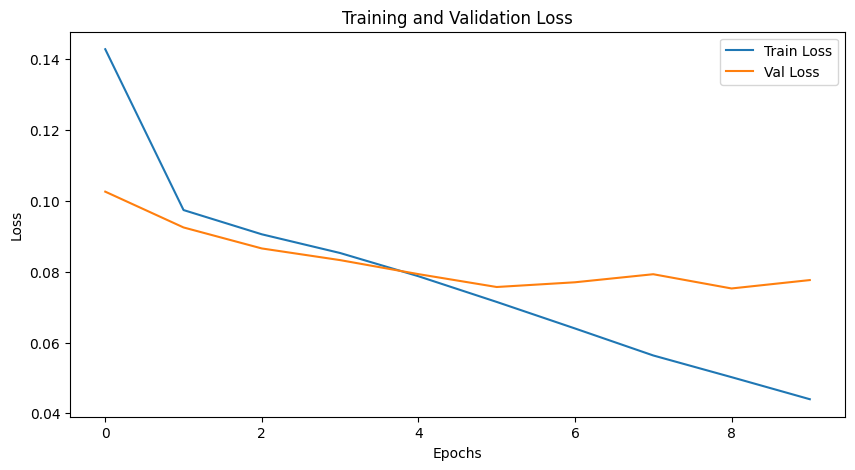

Columnwise MAE: 0.0756
CPU times: user 1min 22s, sys: 21.7 s, total: 1min 44s
Wall time: 9min 3s


In [70]:
%%time
import torch.nn as nn
import torch.nn.functional as F

class SimpleCatModel(nn.Module):
    def __init__(self, output_size=18):
        super(SimpleCatModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Подготовка данных
img_dir = "/content/images/images/train"
csv_file = "/content/train_labels.csv"

# Создаем датасет с аугментациями
dataset = CatKeypointsDataset(csv_file, img_dir, img_size=(224, 224))

# Разбиваем на train и validation (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Создаем DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,     
    pin_memory=True    
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Инициализация модели и обучения
model = SimpleCatModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

# Обучение
history, best_model = train(model, train_loader, val_loader, optimizer, criterion, epochs=10, early_stopping_patience=3)

# Визуализация loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Оценка на валидации
y_pred, y_true, _ = predict(best_model, val_loader)
cmae = np.mean(np.mean(np.abs(y_true - y_pred), axis=0))
print(f"Columnwise MAE: {cmae:.4f}")

#### Эксперимент 2

#### Будем использовать улучшенную модель с BatchNorm

Epoch 1/10
[Batch 50/225] Avg Train Loss: 6.5780
[Batch 100/225] Avg Train Loss: 3.3945
[Batch 150/225] Avg Train Loss: 2.3080
[Batch 200/225] Avg Train Loss: 1.7601
[Batch 225/225] Avg Train Loss: 1.5766

Epoch 1 Summary:
   Train Loss: 1.576648
   Val Loss:   0.107103
    Новая лучшая модель сохранена
Epoch 2/10
[Batch 50/225] Avg Train Loss: 0.1090
[Batch 100/225] Avg Train Loss: 0.1093
[Batch 150/225] Avg Train Loss: 0.1086
[Batch 200/225] Avg Train Loss: 0.1077
[Batch 225/225] Avg Train Loss: 0.1078

Epoch 2 Summary:
   Train Loss: 0.107787
   Val Loss:   0.108760
   Patience: 1/3
Epoch 3/10
[Batch 50/225] Avg Train Loss: 0.1039
[Batch 100/225] Avg Train Loss: 0.1055
[Batch 150/225] Avg Train Loss: 0.1064
[Batch 200/225] Avg Train Loss: 0.1054
[Batch 225/225] Avg Train Loss: 0.1055

Epoch 3 Summary:
   Train Loss: 0.105546
   Val Loss:   0.111485
   Patience: 2/3
Epoch 4/10
[Batch 50/225] Avg Train Loss: 0.1053
[Batch 100/225] Avg Train Loss: 0.1056
[Batch 150/225] Avg Train Loss:

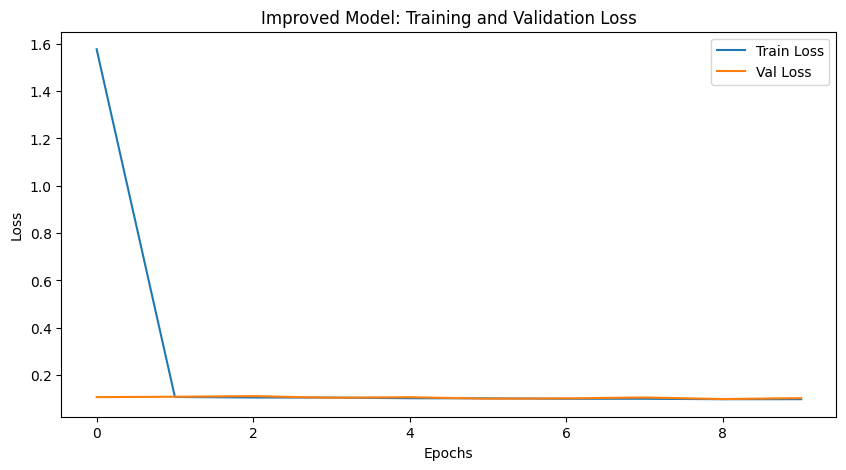

Columnwise MAE: 0.0993
CPU times: user 1min 34s, sys: 20.2 s, total: 1min 55s
Wall time: 8min 55s


In [89]:
%%time
class ImprovedCatModel(nn.Module):
    def __init__(self, output_size=18):
        super(ImprovedCatModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Инициализация улучшенной модели
model2 = ImprovedCatModel()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
criterion2 = nn.L1Loss()

# Обучение
history2, best_model2 = train(model2, train_loader, val_loader, optimizer2, criterion2, epochs=10, early_stopping_patience=3)

# Визуализация loss
plt.figure(figsize=(10, 5))
plt.plot(history2['train_loss'], label='Train Loss')
plt.plot(history2['val_loss'], label='Val Loss')
plt.title('Improved Model: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Оценка на валидации
y_pred2, y_true2, _ = predict(best_model2, val_loader)
cmae2 = np.mean(np.mean(np.abs(y_true2 - y_pred2), axis=0))
print(f"Columnwise MAE: {cmae2:.4f}")

#### Эксперимент 3

#### Реализуем ResNet50

Epoch 1/10
[Batch 50/225] Avg Train Loss: 0.1826
[Batch 100/225] Avg Train Loss: 0.1492
[Batch 150/225] Avg Train Loss: 0.1356
[Batch 200/225] Avg Train Loss: 0.1269
[Batch 225/225] Avg Train Loss: 0.1234

Epoch 1 Summary:
   Train Loss: 0.123363
   Val Loss:   0.106678
    Новая лучшая модель сохранена
Epoch 2/10
[Batch 50/225] Avg Train Loss: 0.0920
[Batch 100/225] Avg Train Loss: 0.0908
[Batch 150/225] Avg Train Loss: 0.0885
[Batch 200/225] Avg Train Loss: 0.0864
[Batch 225/225] Avg Train Loss: 0.0859

Epoch 2 Summary:
   Train Loss: 0.085850
   Val Loss:   0.095680
    Новая лучшая модель сохранена
Epoch 3/10
[Batch 50/225] Avg Train Loss: 0.0732
[Batch 100/225] Avg Train Loss: 0.0724
[Batch 150/225] Avg Train Loss: 0.0713
[Batch 200/225] Avg Train Loss: 0.0700
[Batch 225/225] Avg Train Loss: 0.0690

Epoch 3 Summary:
   Train Loss: 0.069032
   Val Loss:   0.065814
    Новая лучшая модель сохранена
Epoch 4/10
[Batch 50/225] Avg Train Loss: 0.0581
[Batch 100/225] Avg Train Loss: 0.05

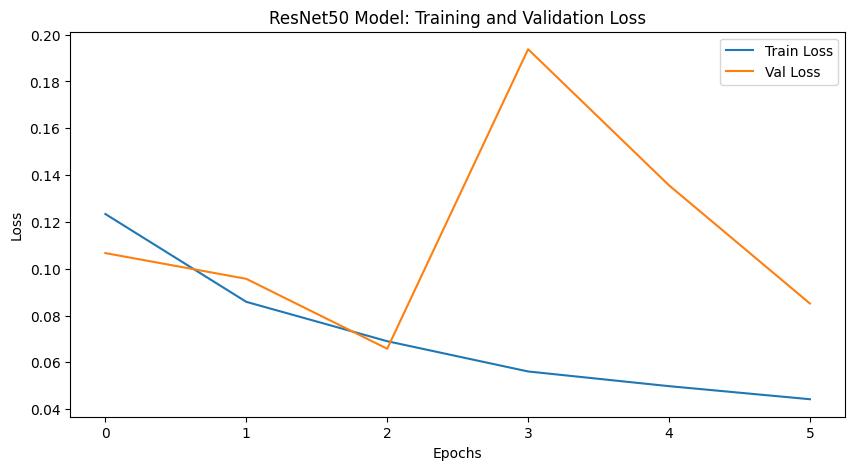

Columnwise MAE: 0.0660
CPU times: user 1min 18s, sys: 10.9 s, total: 1min 29s
Wall time: 5min 26s


In [90]:
%%time
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=18):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet50():
    return ResNet(BasicBlock, [3, 4, 6, 3])

# Инициализация
model3 = ResNet50()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.0001)
criterion3 = nn.L1Loss()

# Обучение
history3, best_model3 = train(model3, train_loader, val_loader, optimizer3, criterion3, epochs=10, early_stopping_patience=3)

# Визуализация loss
plt.figure(figsize=(10, 5))
plt.plot(history3['train_loss'], label='Train Loss')
plt.plot(history3['val_loss'], label='Val Loss')
plt.title('ResNet50 Model: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Оценка на валидации
y_pred3, y_true3, _ = predict(best_model3, val_loader)
cmae3 = np.mean(np.mean(np.abs(y_true3 - y_pred3), axis=0))
print(f"Columnwise MAE: {cmae3:.4f}")

### Evaluation  (оценка качества модели)

#### Сравниваем модели по метрике CMAE и выбираем лучшую для финального предсказания

Сравнение моделей по CMAE:
Эксперимент 1 (Базовая модель): 0.0756
Эксперимент 2 (Улучшенная модель): 0.0993
Эксперимент 3 (ResNet50): 0.0660

Лучшая модель: ResNet50 с CMAE: 0.0660
Модель находится на устройстве: cuda:0


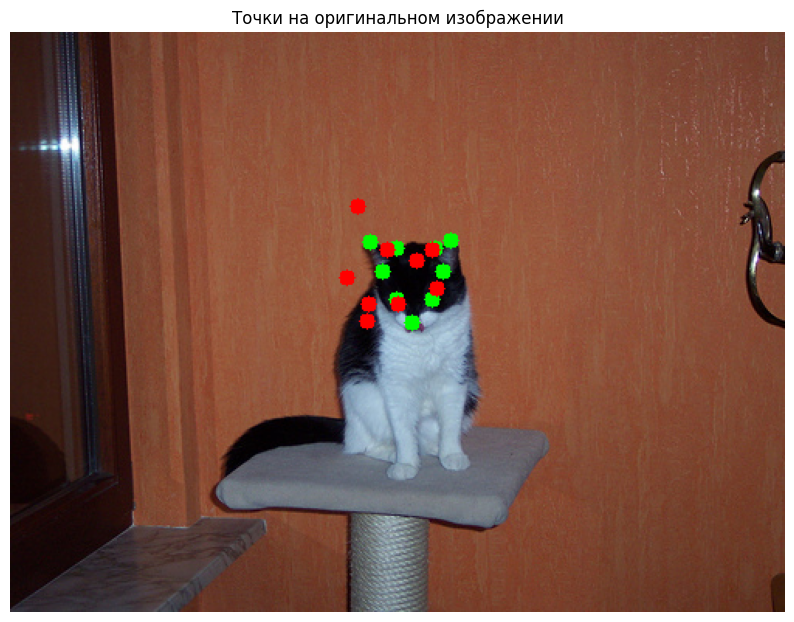

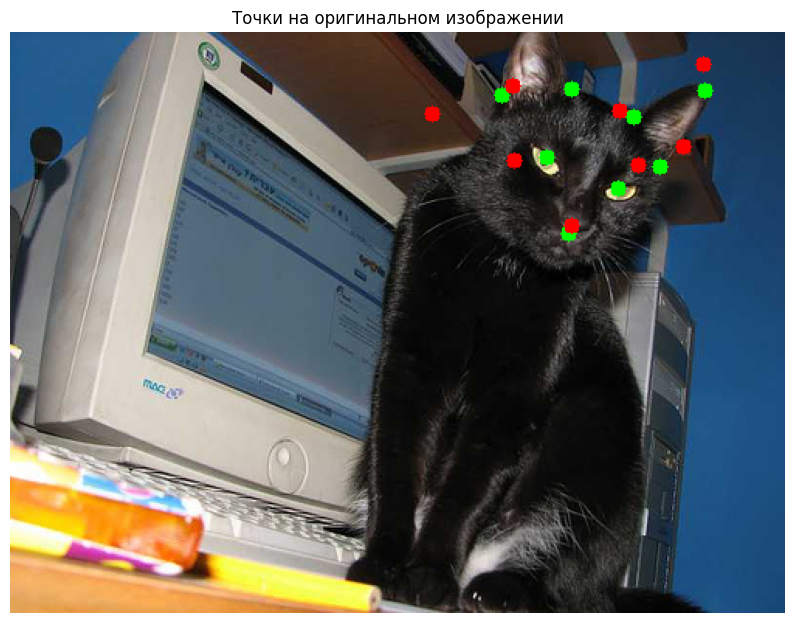

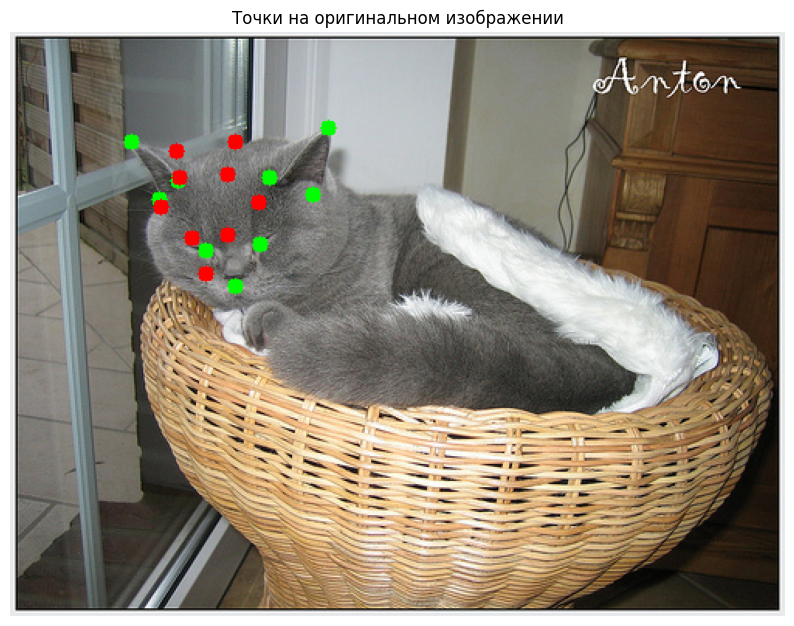

In [91]:
print("Сравнение моделей по CMAE:")
print(f"Эксперимент 1 (Базовая модель): {cmae:.4f}")
print(f"Эксперимент 2 (Улучшенная модель): {cmae2:.4f}")
print(f"Эксперимент 3 (ResNet50): {cmae3:.4f}")

# Выбираем лучшую модель
if cmae < cmae2 and cmae < cmae3:
    best_model = best_model
    best_cmae = cmae
    best_model_name = "SimpleCatModel"
elif cmae2 < cmae3:
    best_model = best_model2
    best_cmae = cmae2
    best_model_name = "ImprovedCatModel"
else:
    best_model = best_model3
    best_cmae = cmae3
    best_model_name = "ResNet50"

print(f"\nЛучшая модель: {best_model_name} с CMAE: {best_cmae:.4f}")

# Определение устройства модели
device = next(best_model.parameters()).device
print(f"Модель находится на устройстве: {device}")

def visualize_on_original(image_path, true_keypoints, pred_keypoints, orig_w, orig_h):
    # Загружаем оригинальное изображение
    orig_image = cv2.imread(image_path)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)

    # Рисуем истинные точки (зеленые)
    for i in range(0, len(true_keypoints), 2):
        # Умножаем нормализованные координаты на оригинальные размеры
        x = int(true_keypoints[i] * orig_w)
        y = int(true_keypoints[i+1] * orig_h)
        cv2.circle(orig_image, (x, y), radius=5, color=(0, 255, 0), thickness=-1)

    # Рисуем предсказанные точки (красные)
    for i in range(0, len(pred_keypoints), 2):
        x = int(pred_keypoints[i] * orig_w)
        y = int(pred_keypoints[i+1] * orig_h)
        cv2.circle(orig_image, (x, y), radius=5, color=(255, 0, 0), thickness=-1)

    plt.figure(figsize=(10, 8))
    plt.imshow(orig_image)
    plt.title("Точки на оригинальном изображении")
    plt.axis('off')
    plt.show()

# Визуализируем несколько примеров на оригинальных изображениях
val_dataset_original = CatKeypointsDataset(
    csv_file="/content/train_labels.csv",
    img_dir="/content/images/images/train",
    img_size=(224, 224)
)

# Разбиваем индексы для визуализации
val_indices = list(range(train_size, len(val_dataset_original)))
for i in range(3):
    idx = val_indices[i]
    img, keypoints, orig_w, orig_h = val_dataset_original[idx]

    # Получаем имя файла
    img_name = val_dataset_original.labels.iloc[idx]['file_name']
    img_path = os.path.join(val_dataset_original.img_dir, img_name)

    # Перемещаем изображение на устройство модели
    img_input = img.unsqueeze(0).to(device)

    # Получаем предсказание
    pred = best_model(img_input).detach().cpu().numpy().flatten()

    # Визуализация на оригинальном изображении
    visualize_on_original(img_path, keypoints, pred, orig_w, orig_h)

#### Готовим предсказания для тестового датасета с использованием лучшей модели.

In [ ]:
class CatTestDataset(Dataset):

    def __init__(self, img_dir, img_size=(224, 224)):
        
        self.img_dir = img_dir
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        self.img_size = img_size

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Загрузка изображения
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = image.shape[:2]

        # Resize изображения
        image = cv2.resize(image, self.img_size)
        image = image / 255.0  # Нормализация в [0,1]

        # Преобразование в тензор
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        return image, img_name, orig_w, orig_h

# Подготовка тестовых данных
test_img_dir = "/content/images/images/test"
test_dataset = CatTestDataset(test_img_dir, img_size=(224, 224))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Получение предсказаний
test_preds, test_dims = predict(best_model, test_loader)

# Денормализация координат
denorm_preds = np.zeros_like(test_preds)
for i in range(len(test_preds)):
    w, h = test_dims[i]
    for j in range(0, len(test_preds[i]), 2):
        denorm_preds[i][j] = test_preds[i][j] * w
        denorm_preds[i][j+1] = test_preds[i][j+1] * h

submission_df = pd.DataFrame({
    'file_names': [f for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
})

keypoint_names = [
    'left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y',
    'mouth_x', 'mouth_y',
    'left_ear_1_x', 'left_ear_1_y', 'left_ear_2_x', 'left_ear_2_y', 'left_ear_3_x', 'left_ear_3_y',
    'right_ear_1_x', 'right_ear_1_y', 'right_ear_2_x', 'right_ear_2_y', 'right_ear_3_x', 'right_ear_3_y'
]

for i, name in enumerate(keypoint_names):
    submission_df[name] = denorm_preds[:, i]

submission_path = '/content/drive/MyDrive/contest3/submission.csv'
submission_df.to_csv(submission_path, index=False)

**Результат лучшей модели на kaggle: Public Score = 37.703**

### Conclusion (Выводы)

#### В ходе выполнения лабораторной работы были решены следующие задачи:

1) Preprocessing: Реализован кастомный датасет с аргументациями (горизонтальное отражение, изменение яркости), что помогло увеличить разнообразие данных и улучшить обобщающую способность модели.
2) Эксперименты:               
    Эксперимент 1: Базовая сверточная сеть показала **CMAE 0.0756**.             
    Эксперимент 2: Модель с BatchNorm показала **CMAE 0.0993**.         
    Эксперимент 3: ResNet50 показала лучший результат (**CMAE 0.0660**), что подтверждает эффективность более глубоких архитектур.               

Что можно улучшить:
Провести более детальный подбор гиперпараметров, но с учетом ограничения ресурсов.           
В связи с ограничением ресурсов (ограничение бесплатной сессии в Colab), не были протестированы модели с более глубокими архетектурами         